# 07 — Business Impact & Targeting Strategy

**Goal.** Convert our causal results into an actionable plan:
1) Quantify the value of reducing late deliveries.  
2) Prioritize customers/orders by *uplift* (CATE = `tau_hat`).  
3) Choose a target size under budget that **maximizes net benefit**.  
4) Produce segment insights, figures, and a short report.

**Inputs**
- `../data/processed/model_df_with_ps.csv` (T, Y, features)
- Either `tau_hat` inside `df` or `../reports/uplift_scores.csv` (order-level CATE)

**Outputs**
- `../reports/impact_tables/*.csv`
- `../reports/figures/*.png`
- `../reports/summary.md` (auto-generated; optionally convert to PDF)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# IO
DATA_DIR   = Path("../data/processed")
REPORT_DIR = Path("../reports")
FIG_DIR    = REPORT_DIR / "figures"
TAB_DIR    = REPORT_DIR / "impact_tables"

for d in [REPORT_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

pd.options.display.float_format = "{:,.4f}".format

In [ ]:
df = pd.read_csv(DATA_DIR / "model_df_with_ps_tau.csv")

# Basic checks
assert "tau_hat" in df.columns, "tau_hat is required."
assert "late_delivery" in df.columns, "late_delivery treatment flag is required."
assert "review_score" in df.columns, "review_score outcome is required."

df["tau_rank"] = df["tau_hat"].rank(pct=True)
df.shape, df[["tau_hat","tau_rank","late_delivery","review_score"]].head()

((110770, 21),
    tau_hat  tau_rank  late_delivery  review_score
 0   0.8147    0.5215              0        4.0000
 1  -5.1567    0.1655              0        4.0000
 2   5.7341    0.8402              0        5.0000
 3  16.6248    0.9814              0        5.0000
 4   1.8660    0.5942              0        5.0000)

## Planning Assumptions

- **Intervention** = operational action that reduces late deliveries for a targeted order/customer (e.g., premium shipping, proactive flagging, carrier upgrade).
- **Effect used**: `tau_hat` = *estimated causal change in review score* if late delivery is prevented.
- **Value** per one review-score point: `VALUE_PER_POINT` (business-side proxy; tune below).
- **Cost** per intervention: `COST_PER_UNIT` (shipping upgrade, SLA, credits, etc.).
- **Budget** (optional): maximum # of interventions or total cost.

We rank orders by `tau_hat` (descending). Higher `tau_hat` ⇒ higher expected gain from preventing a late delivery.

In [3]:
VALUE_PER_POINT   = 1.25   # $ value per 1-point increase in review score
COST_PER_UNIT     = 2.00   # $ cost per intervention
MAX_TARGET_SHARE  = 0.30   # at most target top 30% by tau_hat
BUDGET_DOLLARS    = None
SEED              = 9527

np.random.seed(SEED)

# Keep only rows with finite tau
df_work = df[np.isfinite(df["tau_hat"])].copy()
df_work = df_work.sort_values("tau_hat", ascending=False).reset_index(drop=True)

N = len(df_work)
N_cap = int(N * MAX_TARGET_SHARE)
N, N_cap

(110770, 33231)

In [4]:
# Expected $ benefit per order if we intervene
df_work["benefit_$"] = df_work["tau_hat"] * VALUE_PER_POINT
df_work["cost_$"]    = COST_PER_UNIT

# Rank by tau_hat; cumulative curves
df_work["cum_benefit_$"] = df_work["benefit_$"].cumsum()
df_work["cum_cost_$"]    = df_work["cost_$"].cumsum()
df_work["cum_net_$"]     = df_work["cum_benefit_$"] - df_work["cum_cost_$"]
df_work["target_share"]  = (np.arange(len(df_work)) + 1) / N

# Optional budget: compute feasible max K
if BUDGET_DOLLARS is not None:
    feasible_k = int(min(N_cap, BUDGET_DOLLARS // COST_PER_UNIT))
else:
    feasible_k = N_cap

# Best K among feasible that maximizes net benefit
sub = df_work.iloc[:feasible_k]
best_idx = sub["cum_net_$"].idxmax()
best_row = sub.loc[best_idx]
best_k   = int(best_idx) + 1

best_k, float(best_row["cum_net_$"]), float(best_row["target_share"])

(33231, 239841.2976938067, 0.3)

## Target Recommendation

We choose **K = 33231** (number of targeted orders) that **maximizes net benefit** within constraints.

We also show lift and ROI at that K:
- **Net value** = cumulative benefit – cumulative cost
- **ROI** = (benefit / cost) – 1

In [5]:
def roi(benefit, cost):
    return (benefit / cost - 1.0) if cost > 0 else np.nan

K = best_k
opt = df_work.iloc[K-1]

out = {
    "N_total": N,
    "K_opt": K,
    "target_share": float(opt["target_share"]),
    "cum_benefit_$": float(opt["cum_benefit_$"]),
    "cum_cost_$": float(opt["cum_cost_$"]),
    "cum_net_$": float(opt["cum_net_$"]),
    "ROI": roi(opt["cum_benefit_$"], opt["cum_cost_$"]),
    "VALUE_PER_POINT": VALUE_PER_POINT,
    "COST_PER_UNIT": COST_PER_UNIT,
    "BUDGET_DOLLARS": BUDGET_DOLLARS if BUDGET_DOLLARS is not None else "None",
}

summary = pd.DataFrame([out])
summary.to_csv(TAB_DIR / "summary_at_optimal_K.csv", index=False)
summary

,N_total,K_opt,target_share,cum_benefit_$,cum_cost_$,cum_net_$,ROI,VALUE_PER_POINT,COST_PER_UNIT,BUDGET_DOLLARS
0,110770,33231,0.3000,"306,303.2977","66,462.0000","239,841.2977",3.6087,1.2500,2.0000,None


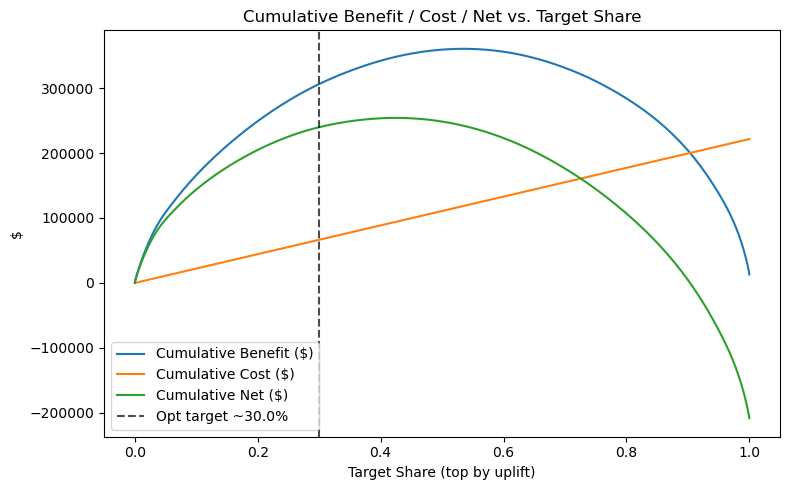

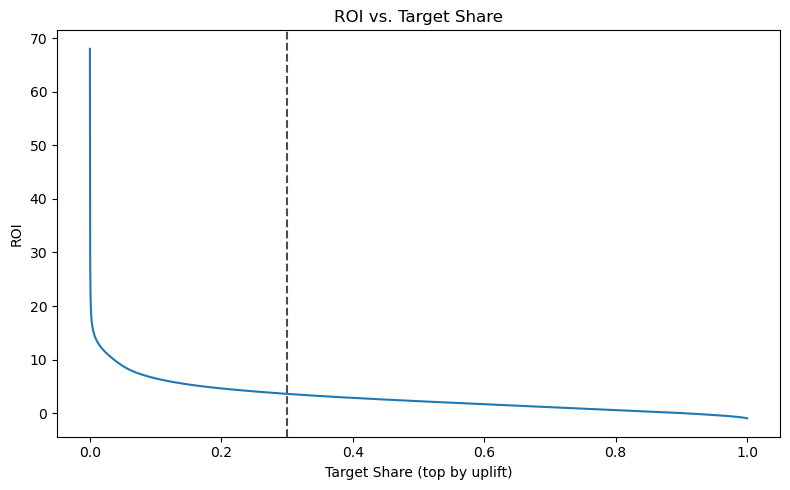

In [6]:
plt.figure(figsize=(8,5))
plt.plot(df_work["target_share"], df_work["cum_benefit_$"], label="Cumulative Benefit ($)")
plt.plot(df_work["target_share"], df_work["cum_cost_$"],    label="Cumulative Cost ($)")
plt.plot(df_work["target_share"], df_work["cum_net_$"],     label="Cumulative Net ($)")
plt.axvline(out["target_share"], color="k", ls="--", alpha=0.7, label=f"Opt target ~{out['target_share']:.1%}")
plt.title("Cumulative Benefit / Cost / Net vs. Target Share")
plt.xlabel("Target Share (top by uplift)")
plt.ylabel("$")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "cumulative_curves.png", dpi=160)
plt.show()

# ROI curve
roi_curve = df_work["cum_benefit_$"] / df_work["cum_cost_$"] - 1.0
plt.figure(figsize=(8,5))
plt.plot(df_work["target_share"], roi_curve)
plt.axvline(out["target_share"], color="k", ls="--", alpha=0.7)
plt.title("ROI vs. Target Share")
plt.xlabel("Target Share (top by uplift)")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig(FIG_DIR / "roi_curve.png", dpi=160)
plt.show()

## Segment Insights

Which segments contain a higher concentration of high uplift?  
We compute segment size and mean `tau_hat` for a few business-relevant dimensions.

In [7]:
SEG_COLS = [
    c for c in ["product_category_name", "customer_state", "seller_state", "payment_type"]
    if c in df_work.columns
]

seg_tables = []
for col in SEG_COLS:
    g = (
        df_work
        .groupby(col)
        .agg(
            n=("tau_hat","size"),
            mean_tau=("tau_hat","mean"),
            p90_tau=("tau_hat", lambda x: np.percentile(x, 90)),
            top10_share=("tau_rank", lambda r: (r>0.9).mean())
        )
        .reset_index()
        .sort_values("mean_tau", ascending=False)
    )
    seg_tables.append((col, g))
    g.to_csv(TAB_DIR / f"segment_{col}.csv", index=False)

SEG_COLS, seg_tables[0][1].head() if seg_tables else "No segment columns available."

(['product_category_name', 'customer_state', 'seller_state', 'payment_type'],
             product_category_name    n  mean_tau  p90_tau  top10_share
 17              cds_dvds_musicais   14    3.0324   8.1742       0.2143
 37  fashion_roupa_infanto_juvenil    8    2.7338   7.4173       0.1250
 27                   dvds_blu_ray   63    2.3496   7.6518       0.1429
 38        fashion_roupa_masculina  131    2.0049   8.8553       0.1374
 34               fashion_calcados  261    1.9495   6.8223       0.0881)

## Export Target List

We export the **top K** orders as a CSV for action (proactive ops / shipping upgrade).  
This would typically include: order id, customer id, expected uplift, cost and net value.

In [8]:
ID_COLS = [c for c in ["order_id","customer_id","seller_id"] if c in df_work.columns]
target_cols = ID_COLS + ["tau_hat", "benefit_$", "cost_$"]
targets = df_work.loc[:K-1, target_cols]
targets.to_csv(TAB_DIR / "target_list_topK.csv", index=False)
targets.head()

,tau_hat,benefit_$,cost_$
0,110.4312,138.0390,2.0000
1,106.5335,133.1669,2.0000
2,88.2534,110.3167,2.0000
3,70.9042,88.6303,2.0000
4,61.4498,76.8123,2.0000
